In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Preparing data and a linear model


### Explore the data with some EDA

In [2]:
spy_df = pd.read_csv('SPY.csv', parse_dates = ['Date'], index_col = 'Date')
lng_df = pd.read_csv('LNG.csv', parse_dates = ['Date'], index_col = 'Date')

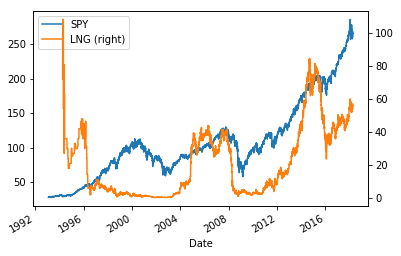

In [3]:
# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend = True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

### Correlations

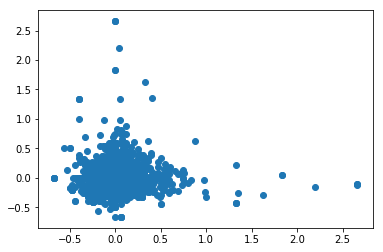

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.034733
5d_close_future_pct     -0.034733             1.000000


In [4]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

print(corr)

### Create moving average and RSI features

In [5]:
import talib
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200 ]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)

### Create features and targets

In [6]:
lng_df.sample(5)

Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
2009-11-11       2.01    498600.0            2.000            -0.004975   
1994-06-30      36.00         0.0           36.000             0.000000   
2004-06-23       9.85    381600.0            9.785            -0.006599   
1999-01-12       3.00      9600.0            4.000             0.333333   
2005-10-26      37.40   1123700.0           37.800             0.010695   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
2009-11-11     -0.077982  1.158849  25.260539  1.263018  35.632647  1.356318   
1994-06-30      0.000000  1.000000  41.189216  1.058333  42.320241  1.345000   
2004-06-23      0.095662  0.847788  74.129951  0.748071  63.640355  0.784964   
1999-01-12      0.500000  0.762857  62.036319  0.754889  57.211318  0.718800   
2005-10-26      0.041493  0.961345  51.142278  1.020490  51.065563  1.018444   

                rsi50     ma200     rsi200  
Date                                        
2009-11-11  40.546665  1.738980  44.029013  
1994-06-30  42.307692       NaN        NaN  
2004-06-23  60.011380  0.616718  58.689752  
1999-01-12  53.343860  1.143067  47.330606  
2005-10-26  52.132279  0.918271  55.087920

In [7]:
feature_names = ['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']

# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
corr

5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.002773  0.005459 -0.023049   
5d_close_pct                   -0.002773      1.000000 -0.719633  0.472503   
ma14                            0.005459     -0.719633  1.000000 -0.656969   
rsi14                          -0.023049      0.472503 -0.656969  1.000000   
ma30                            0.038721     -0.529670  0.866246 -0.734508   
rsi30                          -0.018082      0.340750 -0.548970  0.940057   
ma50                            0.057731     -0.392255  0.726730 -0.694763   
rsi50                          -0.011972      0.261279 -0.476323  0.844811   
ma200                           0.142356     -0.137455  0.439388 -0.432523   
rsi200                          0.007269      0.115605 -0.279927  0.409289   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.038721 -0.018082  0.057731 -0.011972  0.142356   
5d_close_pct        -0.529670  0.340750 -0.392255  0.261279 -0.137455   
ma14                 0.866246 -0.548970  0.726730 -0.476323  0.439388   
rsi14               -0.734508  0.940057 -0.694763  0.844811 -0.432523   
ma30                 1.000000 -0.681679  0.934288 -0.617330  0.602890   
rsi30               -0.681679  1.000000 -0.704751  0.964814 -0.530419   
ma50                 0.934288 -0.704751  1.000000 -0.666456  0.682971   
rsi50               -0.617330  0.964814 -0.666456  1.000000 -0.591833   
ma200                0.602890 -0.530419  0.682971 -0.591833  1.000000   
rsi200              -0.381602  0.517321 -0.434457  0.655516 -0.508826   

                       rsi200  
5d_close_future_pct  0.007269  
5d_close_pct         0.115605  
ma14                -0.279927  
rsi14                0.409289  
ma30                -0.381602  
rsi30                0.517321  
ma50                -0.434457  
rsi50                0.655516  
ma200               -0.508826  
rsi200               1.000000

### Check the correlations

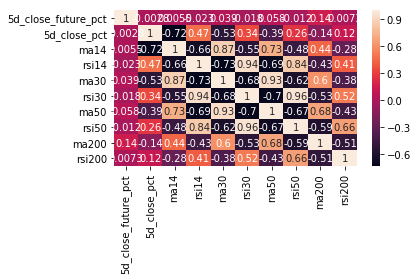

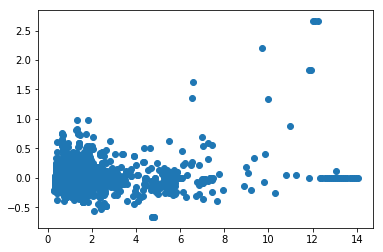

In [8]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(lng_df['ma200'], lng_df['5d_close_future_pct'])
plt.show()

### Create train and test features

In [9]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

((5847, 10), (4969, 10), (878, 10))


### Fit a linear model

In [10]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary)

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

<bound method OLSResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x1a144d8150>>
const           6.587567e-01
5d_close_pct    1.165180e-02
ma14            1.003838e-04
rsi14           1.114091e-03
ma30            3.675255e-01
rsi30           4.643474e-01
ma50            3.860107e-01
rsi50           1.957027e-01
ma200           1.920495e-36
rsi200          3.463175e-02
dtype: float64


### Evaluate our results

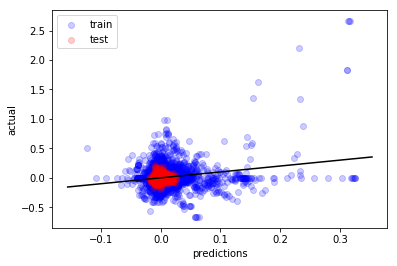

In [11]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha =0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## Machine learning tree methods

### Feature engineering from volume

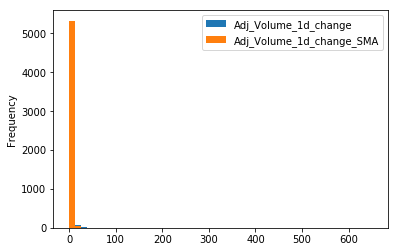

In [12]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change(1)
lng_df = lng_df.replace([np.inf, -np.inf], np.nan)
lng_df = lng_df.dropna()
lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

### Create day-of-week features

In [13]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place
lng_df.to_csv('lng_df.csv')
lng_df.head()

Adj_Close  Adj_Volume  5d_future_close  5d_close_future_pct  \
Date                                                                      
1995-08-11      42.00         0.0            42.00                0.000   
1995-10-23      39.00         0.0            39.00                0.000   
1995-11-01      38.28         0.0            38.28                0.000   
1995-11-13      48.00         0.0            42.00               -0.125   
1995-11-15      42.00       400.0            42.00                0.000   

            5d_close_pct      ma14      rsi14      ma30      rsi30      ma50  \
Date                                                                           
1995-08-11      0.166667  0.877551  99.835985  0.841667  97.042609  0.794286   
1995-10-23     -0.161290  1.115385  28.969562  1.094872  41.377227  1.087692   
1995-11-01     -0.018462  1.086095  25.992179  1.095925  38.638756  1.096426   
1995-11-13      0.253918  0.830714  78.916200  0.866833  71.746827  0.870100   
1995-11-15      0.097179  0.964694  51.523891  0.993048  52.655408  0.995829   

                rsi50     ma200     rsi200  Adj_Volume_1d_change  \
Date                                                               
1995-08-11  89.026745  0.675536  46.999192             -1.000000   
1995-10-23  50.432460  0.851538  46.056387             -1.000000   
1995-11-01  47.971520  0.879710  45.790450             -1.000000   
1995-11-13  70.676817  0.714244  49.858929             -1.000000   
1995-11-15  55.071995  0.820564  47.624751             -0.973333   

            Adj_Volume_1d_change_SMA  weekday_1  weekday_2  weekday_3  \
Date                                                                    
1995-08-11                 -1.000000          0          0          0   
1995-10-23                 -1.000000          0          0          0   
1995-11-01                 -1.000000          0          1          0   
1995-11-13                 -1.000000          0          0          0   
1995-11-15                 -0.994667          0          1          0   

            weekday_4  
Date                   
1995-08-11          1  
1995-10-23          0  
1995-11-01          0  
1995-11-13          0  
1995-11-15          0

### Examine correlations of the new features

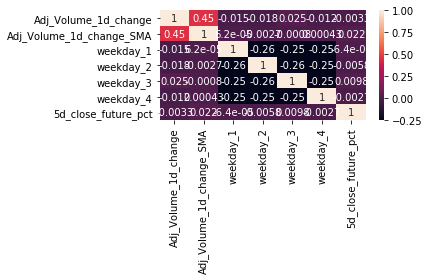

In [14]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(lng_df[new_features + ['5d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

### Fit a decision tree

In [15]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.999999955719
-4.21797777823


### Try different max depths

In [16]:
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

('max_depth=', '3')
0.313193418301
(-0.13266335994720246, '\n')
('max_depth=', '5')
0.396659029132
(-0.25605694567489268, '\n')
('max_depth=', '10')
0.514046645715
(-0.40622559597558761, '\n')


### Check our results

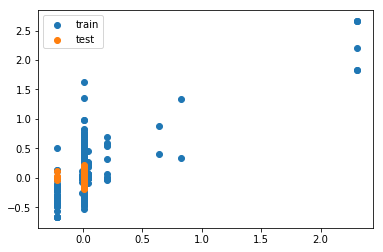

In [17]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

### Fit a random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.937700187884
-1.04612672443


### Tune random forest hyperparameters

In [19]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

(-0.06626413147304766, {'n_estimators': 200, 'max_features': 4, 'random_state': 42, 'max_depth': 3})


### Evaluate performance

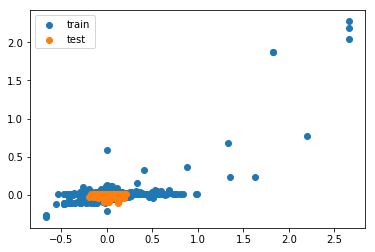

In [20]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

### Random forest feature importances

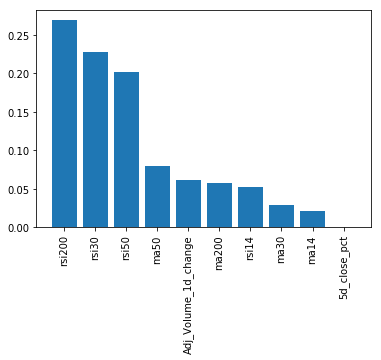

In [21]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

### A gradient boosting model

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.340285859674
-0.0849408640959


### Gradient boosting feature importances

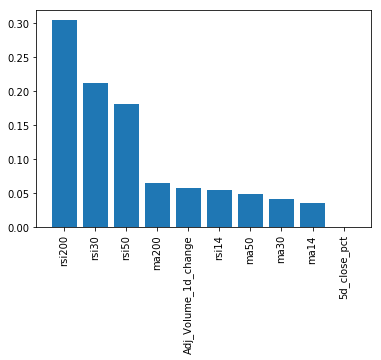

In [23]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## Neural networks and KNN

### Standardizing data

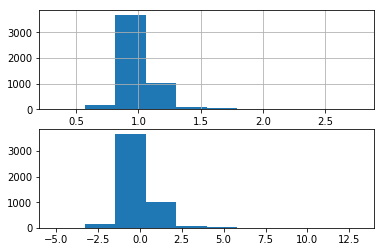

In [24]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

### Optimize n_neighbors

In [25]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print(' ')  # prints a blank line

('n_neighbors =', 2)
train, test scores
0.738667806995
-4.45643220515
 
('n_neighbors =', 3)
train, test scores
0.640507360939
-3.09198694142
 
('n_neighbors =', 4)
train, test scores
0.535935543507
-2.93789843656
 
('n_neighbors =', 5)
train, test scores
0.454504141998
-2.44121462322
 
('n_neighbors =', 6)
train, test scores
0.407388741119
-2.15429088293
 
('n_neighbors =', 7)
train, test scores
0.358993669163
-2.1262345346
 
('n_neighbors =', 8)
train, test scores
0.347943790886
-1.90218840725
 
('n_neighbors =', 9)
train, test scores
0.324231981045
-1.71880485815
 
('n_neighbors =', 10)
train, test scores
0.301315705485
-1.51617915722
 
('n_neighbors =', 11)
train, test scores
0.287087071618
-1.34058450346
 
('n_neighbors =', 12)
train, test scores
0.272740780995
-1.22770302833
 


### Evaluate KNN performance

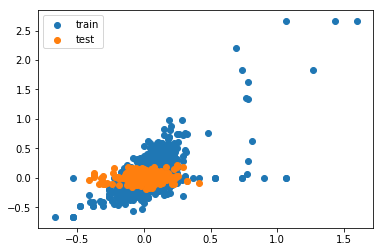

In [26]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors= 5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label = 'test')
plt.legend()
plt.show()